In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timezone
import time 
start_time = time.time()

In [2]:
df_fuel_trans = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv')
df_truck_info = pd.read_csv('data/IBGEFILE.UNITS.csv')
df_fuel_opt = pd.read_csv('data/BGEIDSC.EF2EFFP.csv')
df_level = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv')
df_events = pd.read_csv('data/Extranet2.ExactFuelEvents.csv')
df_performance = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv')
df_events = df_events.drop(columns=['EquipmentType']) ## - 1 unique entry
df_event_level = pd.merge(df_events, df_level, how='left', left_on='ESS_Id', right_on='ExactFuelEventId')

In [3]:
fuels = ['ULSD', 'FUEL', 'CDSL', 'DEFC', 'DSL1', 'BDSL']

In [4]:
driver_events = df_events.DriverID.value_counts().sort_values(ascending=False)

,EquipmentID,min_odo,max_odo,odo_change
0,0,0.0,557458.4,557458.4
1,243,92478.1,138667.3,46189.2
2,244,112387.3,112608.6,221.3
3,245,504221.7,565465.0,61243.3
4,246,536714.7,604281.4,67566.7
5,301,342355.5,352014.6,9659.1
6,302,244162.7,281027.2,36864.5
7,303,231775.7,243508.7,11733.0
8,304,181312.8,306788.3,125475.5
9,305,227952.9,264257.9,36305.0


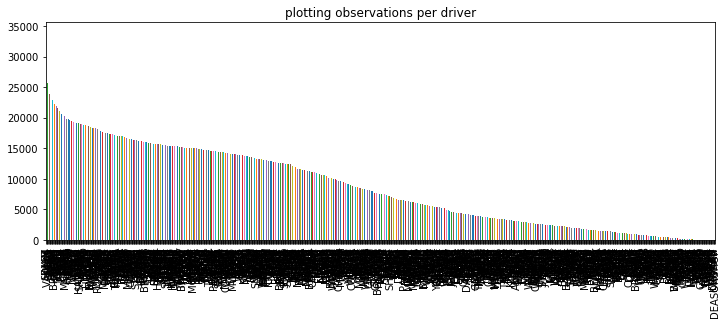

In [6]:
driver_events.plot(kind='bar', figsize=(12,4), title='plotting observations per driver');

In [7]:
#driver_events.plot(kind='hist', bins=95, title='table observations by driver');

In [8]:
#start_time_a = time.time()
#
#_ = plt.hist(driver_events, bins=50)
#plt.show()

#print (time.time() - start_time_a)

In [9]:
#fg = sns.FacetGrid(data=df_events, hue='EquipmentID')
#fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [10]:
truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713) & (df_event_level['IgnitionStatus'] == 1)] 

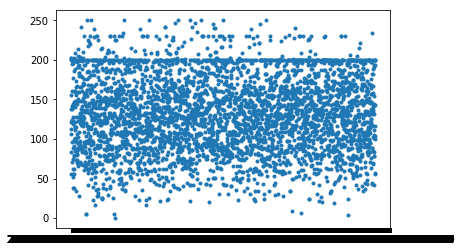

In [11]:
plt.plot(truck_1713.EventTimeStamp, truck_1713.TankLevelGallons, marker='.', linestyle='none') 
plt.show()
## redo with fuel levels ##

In [12]:
truck_1713_dec = truck_1713
truck_1713_dec['fuel_delta'] = truck_1713_dec.TankLevelGallons - truck_1713_dec.TankLevelGallons.shift(1)
truck_1713_dec['odometer_delta'] = truck_1713_dec.Odometer - truck_1713_dec.Odometer.shift(1)
truck_1713_dec['mpg_change'] = truck_1713_dec.odometer_delta / truck_1713_dec.fuel_delta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [13]:
truck_1713_dec[['TankLevelGallons','EventTimeStamp','Odometer', 'odometer_delta', 'fuel_delta','mpg_change', 'EFReportReason']]

,TankLevelGallons,EventTimeStamp,Odometer,odometer_delta,fuel_delta,mpg_change,EFReportReason
2,121.80,2017-01-01 00:04:15.053,377577.4,NaN,NaN,NaN,2
90,155.40,2017-01-01 01:04:15.443,377644.0,66.6,33.60,1.982143,2
115,199.40,2017-01-01 01:24:45.490,377665.4,21.4,44.00,0.486364,2
129,55.80,2017-01-01 01:37:55.430,377666.9,1.5,-143.60,-0.010446,0
141,106.80,2017-01-01 01:52:55.443,377681.9,15.0,51.00,0.294118,2
148,202.63,2017-01-01 01:58:25.507,377682.2,0.3,95.83,0.003131,0
179,202.63,2017-01-01 01:58:25.507,377682.2,0.0,0.00,NaN,0
193,83.60,2017-01-01 02:13:25.587,377687.8,5.6,-119.03,-0.047047,2
217,137.40,2017-01-01 02:28:25.803,377701.3,13.5,53.80,0.250929,2
218,112.00,2017-01-01 02:46:15.850,377715.6,14.3,-25.40,-0.562992,2


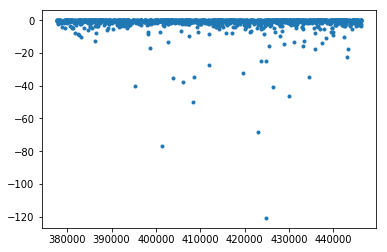

In [14]:
truck_1713_map = truck_1713_dec
truck_1713_map = truck_1713_map[truck_1713_map['mpg_change'] < 0]
plt.plot(truck_1713_map.Odometer, truck_1713_map.mpg_change, marker='.', linestyle='none')
plt.show()

In [15]:
#plt.plot(truck_1713_map.Odometer, truck_1713_map.TankLevelGallons, marker='.', linestyle='none')
#plt.show()


In [16]:
truck_1713_map_wSpeed = truck_1713_map[truck_1713_map['Speed'] > 0]

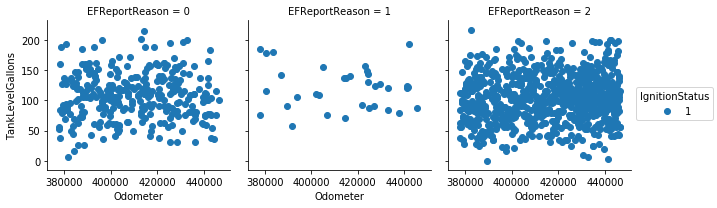

In [17]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'Odometer', 'TankLevelGallons').add_legend()

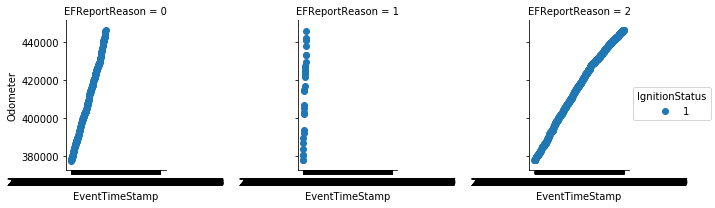

In [18]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [19]:
from datetime import timezone
truck_1713_map_wSpeed['EventTimeStamp'] = pd.to_datetime(truck_1713_map_wSpeed['EventTimeStamp'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
truck_1713_map_wSpeed = truck_1713_map_wSpeed.sort_values(by=['EventTimeStamp'])

In [30]:
truck_1713_map_wSpeed['month_ts'] = pd.DatetimeIndex(truck_1713_map_wSpeed['EventTimeStamp']).month

In [31]:
truck_1713_map_wSpeed

,Id_x,ESS_Id,EventTimeStamp,EquipmentID,MCTNumber,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,...,Id_y,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,fuel_delta,odometer_delta,mpg_change,year_month_ts,month_ts
129,12649235,13640422,2017-01-01 01:37:55.430,1713,105438293,RUSR,34.63710,-84.97768,2017-01-01 01:37:57.000,67,...,11282929.0,1.0,27.9,55.80,13640422.0,-143.60,1.5,-0.010446,2017-01-01 01:37:55.430,1
193,12649299,13640479,2017-01-01 02:13:25.587,1713,105438293,RUSR,34.45262,-84.87518,2017-01-01 02:13:27.000,61,...,11282986.0,1.0,41.8,83.60,13640479.0,-119.03,5.6,-0.047047,2017-01-01 02:13:25.587,1
218,12649324,13640521,2017-01-01 02:46:15.850,1713,105438293,RUSR,34.46862,-84.49788,2017-01-01 02:42:22.000,9,...,11283028.0,1.0,56.0,112.00,13640521.0,-25.40,14.3,-0.562992,2017-01-01 02:46:15.850,1
15735,12664956,13657294,2017-01-02 19:53:41.533,1713,105438293,RUSR,33.81130,-84.25105,2017-01-02 19:53:44.000,61,...,11298415.0,1.0,24.8,62.00,13657294.0,-66.00,13.5,-0.204545,2017-01-02 19:53:41.533,1
16099,12665320,13657671,2017-01-02 20:53:41.953,1713,105438293,RUSR,34.42607,-84.41943,2017-01-02 20:53:44.000,41,...,11298792.0,1.0,18.9,37.80,13657671.0,-24.20,61.8,-2.553719,2017-01-02 20:53:41.953,1
32520,12681763,13676656,2017-01-03 16:30:18.213,1713,105438293,RUSR,33.92038,-84.48430,2017-01-03 16:30:19.000,2,...,11315873.0,1.0,24.1,55.43,13676656.0,-120.97,37.1,-0.306688,2017-01-03 16:30:18.213,1
33911,12683154,13678157,2017-01-03 17:45:05.227,1713,105438293,RUSR,33.54944,-84.55318,2017-01-03 17:45:09.000,6,...,11317226.0,1.0,32.7,75.21,13678157.0,-124.79,0.6,-0.004808,2017-01-03 17:45:05.227,1
34272,12683515,13678450,2017-01-03 18:01:45.273,1713,105438293,RUSR,33.54947,-84.55334,2017-01-03 18:01:49.000,1,...,11317443.0,1.0,26.1,52.20,13678450.0,-92.00,0.2,-0.002174,NaT,1
35333,12684576,13679579,2017-01-03 19:16:45.430,1713,105438293,RUSR,33.55480,-83.37175,2017-01-03 19:16:49.000,67,...,11318478.0,1.0,28.1,56.20,13679579.0,-42.80,65.6,-1.532710,NaT,1
37085,12686328,13681399,2017-01-03 22:13:56.557,1713,105438293,RUSR,34.07529,-80.99722,2017-01-03 22:14:00.000,2,...,11320053.0,1.0,93.0,186.00,13681399.0,-13.41,5.2,-0.387770,NaT,1


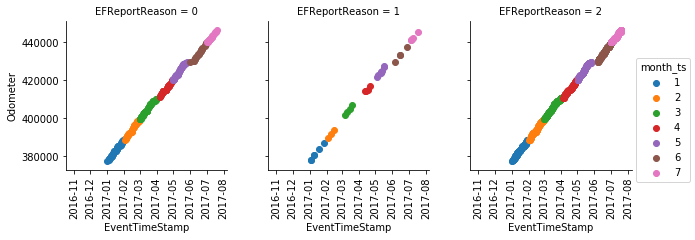

In [32]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='month_ts', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 90);

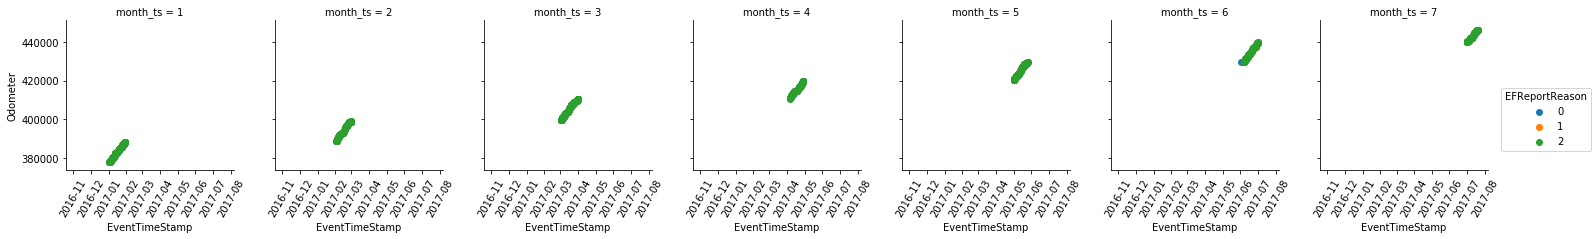

In [33]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='month_ts')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 60);

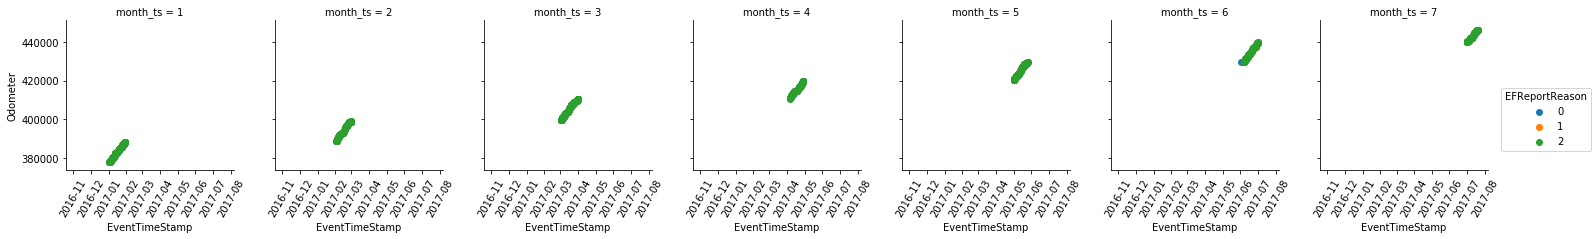

In [34]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='month_ts')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 60);

In [35]:
truck_1713_map_wSpeed.head()

,Id_x,ESS_Id,EventTimeStamp,EquipmentID,MCTNumber,DriverID,Latitude,Longitude,LocationTimeStamp,Speed,...,Id_y,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,fuel_delta,odometer_delta,mpg_change,year_month_ts,month_ts
129,12649235,13640422,2017-01-01 01:37:55.430,1713,105438293,RUSR,34.63710,-84.97768,2017-01-01 01:37:57.000,67,...,11282929.0,1.0,27.9,55.8,13640422.0,-143.60,1.5,-0.010446,2017-01-01 01:37:55.430,1
193,12649299,13640479,2017-01-01 02:13:25.587,1713,105438293,RUSR,34.45262,-84.87518,2017-01-01 02:13:27.000,61,...,11282986.0,1.0,41.8,83.6,13640479.0,-119.03,5.6,-0.047047,2017-01-01 02:13:25.587,1
218,12649324,13640521,2017-01-01 02:46:15.850,1713,105438293,RUSR,34.46862,-84.49788,2017-01-01 02:42:22.000,9,...,11283028.0,1.0,56.0,112.0,13640521.0,-25.40,14.3,-0.562992,2017-01-01 02:46:15.850,1
15735,12664956,13657294,2017-01-02 19:53:41.533,1713,105438293,RUSR,33.81130,-84.25105,2017-01-02 19:53:44.000,61,...,11298415.0,1.0,24.8,62.0,13657294.0,-66.00,13.5,-0.204545,2017-01-02 19:53:41.533,1
16099,12665320,13657671,2017-01-02 20:53:41.953,1713,105438293,RUSR,34.42607,-84.41943,2017-01-02 20:53:44.000,41,...,11298792.0,1.0,18.9,37.8,13657671.0,-24.20,61.8,-2.553719,2017-01-02 20:53:41.953,1


In [36]:
#df_fuel_trans
df_fuel_trans_fuels = df_fuel_trans[df_fuel_trans['TRNPI1'].isin(fuels)]
df_fuel_trans_fuels = df_fuel_trans_fuels.drop(columns=['TRNPI2','TRNPI3','TRNPI4','TRNPI5','TRNPI6','TRNPQ2','TRNPQ3','TRNPQ4','TRNPQ5','TRNPQ6'])

In [66]:
fuel_by_truck

,TRNUNT,TRNPI1,TRNPQ1
0,,ULSD,2887.02
1,1513,ULSD,50.02
2,1520,ULSD,2767.74
3,1521,ULSD,4406.22
4,1522,ULSD,3662.87
5,1523,ULSD,1909.91
6,1524,ULSD,3912.98
7,1525,ULSD,427.13
8,1526,ULSD,1942.99
9,1527,ULSD,4736.10


In [55]:
fuel_by_truck = df_fuel_trans_fuels.groupby(['TRNUNT','TRNPI1'], as_index=False)['TRNPQ1'].sum()

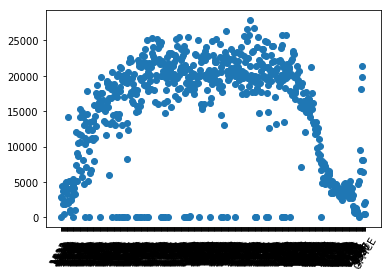

In [63]:
############### FUEL BY TRUCK SHOWN ###################
#### NEED TO BRING IN ODOMETER CHANGE (Max - Min) ####
################## split by month? ##################

_ = plt.scatter('TRNUNT','TRNPQ1',data=fuel_by_truck)
_ = plt.xticks(rotation=60)
plt.show()

In [86]:
miles_by_truck = pd.DataFrame()
miles_by_truck['min_odo'] = df_events.groupby(['EquipmentID'])['Odometer'].min()
miles_by_truck['max_odo'] = df_events.groupby(['EquipmentID'])['Odometer'].max()
miles_by_truck['odo_change'] = (miles_by_truck['max_odo'] - miles_by_truck['min_odo'])
miles_by_truck = miles_by_truck.reset_index()

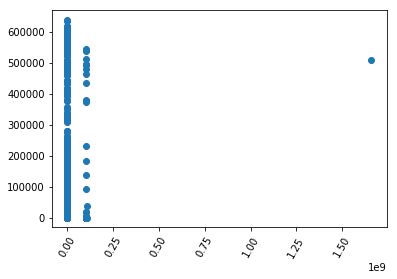

In [87]:
_ = plt.scatter('EquipmentID','odo_change',data=miles_by_truck)
_ = plt.xticks(rotation=60)
plt.show()

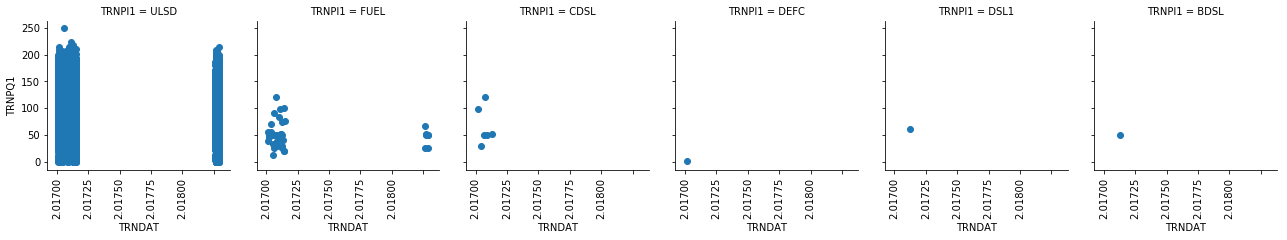

In [38]:
fg = sns.FacetGrid(data=df_fuel_trans_fuels, col='TRNPI1')
fg.map(plt.scatter,'TRNDAT','TRNPQ1')
fg.set_xticklabels(rotation = 90);

In [39]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 760.9189395904541 seconds ---
